# Homework 1: Bars

**Question 1:**

Figure 1 shows a 1D bar of uniform cross-section fixed at the left-end. It has length $ l=1 m $ and section area $ A=0.0002 m^2 $. It is subjected to a uniform body force $ F_x $ and a concentrated force $ F_s $ at the right end. The young’s modulus of the material is $ E=1.0×10^{10} N/m^2 $. Using analytical (exact) method, obtain the distribution and the maximum value of the displacement, strain and stress, for the following cases.

1) $ F_x = 1000 N/m $ and $ F_s = 1000 N $;
2) $ F_x = 100x + 1000 N/m $ and $ F_s = 0 $

<img src="images/hw1-1.png" alt=" " width="350"/><br>

A bar with uniform cross-section fixed at the left end.

In [17]:
# Place curse in this cell, and press Ctrl+Enter to import dependences. 
import sys                         # for accessing the computer system
sys.path.append('../grbin/')  # Change to the directory in your system 

from commonImports import *       # Import dependences from '../grbin/'

from continuum_mechanics import vector 
init_printing(use_unicode=True)      # For latex-like quality printing 
np.set_printoptions(precision=4,suppress=True, 
       formatter={'float': '{:0.4e}'.format})   # Digits in print-outs

1. 

In [18]:
def solver1D2(E, A, bf, l, bc0, bcl, key='disp'):
    
    '''Solves mechanics prolems for 1D bars subjected to body 
    force bf: u,xx=-bf(x)/EA, with BCs: u(0)=bc0; u(l)=bcl or fR=bcl.
    Input: bf, body force; l, the length of the bar; 
           bcl, condition at x=l; 
           key="disp", displacement condition at a boundary;
           otherwise a force condition
    Return: u, E*u_x, u_xx ''' 
    
    # Integrate twice to obtain the general solutions in u_x and u: 
    u_x = sp.integrate(-bf/E/A,(x))+ c0  #c0: integration constant
    u   = sp.integrate(u_x,(x))+ c1      #c1: integration constant
    
    # Solve for the integration constants: 
    if key == "disp":
        consts=sp.solve([u.subs(x,0)-bc0, u.subs(x,l)-bcl],  [c0, c1])
    else:
        consts=sp.solve([u.subs(x,0)-bc0,u_x.subs(x,l)-bcl/E/A],[c0,c1])
        
    # Substitute the constants back to the general solutions, to obtain
    # solutions that satisfy the BCs:
    u   =   u.subs({c0:consts[c0],c1:consts[c1]})
    u   =   u.expand().simplify()
    u_x = u_x.subs({c0:consts[c0],c1:consts[c1]})
    u_x = u_x.expand().simplify()
    u_xx = sp.diff(u_x,x)
    
    print(f'output from solver1D2(): u, 𝜎, u_xx')
    return u.expand(), (E*u_x).expand(), u_xx.expand()

In [19]:
E, A, l = symbols('E, A, l', nonnegative=True)   #l: length of the bar
x, q, bf, c0, c1 = symbols('x, q, b_f, c0, c1')

fL, fR, uL,uR = symbols('f_L, f_R, u_L, u_R')      
# fL: force at the Left-end; fR: force at the Right-end
# uL: displacement at the Left-end; uR: displacement at the Right-end

bf = sp.Function('b_f')(x)                       # 1D body-force (N/m)
title = ["Displacement", "Stress"]

# Consider the distrubted force is a constant q 
bf = 1000
u = solver1D2(E, A, bf, l, uL, fR, key='force')

# chech whether the DE is satisfied. 
print(f'Is solution correct? {u[2] == -bf/E/A}') 
u                    # solutions: u; E*u,x; u,xx

output from solver1D2(): u, 𝜎, u_xx
Is solution correct? True


In [20]:
ux_cq=[u[i].subs({E:1e10,A:0.0002,l:1,uL:0,fR:1000}) for i in range(len(u))]
ux_cq

In [21]:
def plot2curveS(u, xL=0., xR=1., title="f_title"):
    
    '''Print out maximum values and loctions, as well as stationary 
    points, and the values at the stationary points, and boundaries.
    '''
    x = symbols('x')
    dx = 0.01; dxr = dx*10       # x-step
    xi = np.arange(xL, xR+dx, dx)
    uf = sp.lambdify((x), u[0], 'numpy')   #convert Sympy f to numpy f 
    yi = uf(xi)
    if type(yi) != np.ndarray:              #in case, uf is a constant
        #type(yi) == int or type(yi) == float: # or len(yi)==1:  
        xi = np.arange(xL, xR+dxr, dxr)
        yi = float(yi)*np.ones_like(xi)

    fig, ax1 = plt.subplots(figsize=(5.,1.), dpi=300)
    fs = 8     # fontsize
    color = 'black'
    ax1.set_xlabel('location x', fontsize=fs)
    ax1.set_ylabel(title[0], color=color, fontsize=fs)
    ax1.plot(xi, yi, color=color)
    ax1.grid(color='r',ls=':',lw=.3, which='both') # Use both tick 
    ax1.tick_params(axis='x', labelcolor=color, labelsize=fs)
    ax1.tick_params(axis='y', labelcolor=color, labelsize=fs)

    vmax = yi[yi.argmax()]
    max_l = np.argwhere(yi == vmax)
    ax1.plot(xi[max_l],  yi[max_l], 'r*', markersize=4)
    print(f'Maximum {title[0]} value={vmax:.3e}, at x={xi[max_l][0][0]}')
    
    uf = sp.lambdify((x), u[1], 'numpy') #convert Sympy f to numpy f 
    xi = np.arange(xL, xR+dx, dx)
    yi2 = uf(xi)
    if type(yi2) != np.ndarray: # or len(yi2) == 1:
        xi = np.arange(xL, xR+dxr, dxr)
        yi2 = float(yi2)*np.ones_like(xi)

    m1, m2, m3 = np.partition(abs(yi2), 2)[0:3]
    msl=[np.where(abs(yi2)==m1)[0][0],np.where(abs(yi2)==m2)[0][0],
             np.where(abs(yi2)==m3)[0][0]]
    
    vmax = yi2[yi2.argmax()]
    max_l = np.argwhere(yi2 == vmax)
    print(f'Maximum {title[1]} value={vmax:.3e}, at x={xi[max_l][0][0]}')
        
    if abs(xi[msl[2]]-xi[msl[1]])<2*dx:
        if abs(yi2[msl[2]]-0.)<abs(yi2[msl[1]]-0.): msl.pop(1)
        else: msl.pop(2) 
    if len(msl) > 2:
        if abs(xi[msl[2]]-xi[msl[0]])<2*dx:
            if abs(yi2[msl[2]]-0.)<abs(yi2[msl[0]]-0.): msl.pop(0)
            else: msl.pop(2)  
    if len(msl) > 1:
        if abs(xi[msl[1]]-xi[msl[0]])<2*dx:
            if abs(yi2[msl[1]]-0.)<abs(yi2[msl[0]]-0.): msl.pop(0)
            else: msl.pop(1)
         
    ax2 = ax1.twinx()  # instantiate second axes sharing the same x-axis

    color = 'blue'
    ax2.set_ylabel(title[1], color=color, fontsize=fs) 
    ax2.plot(xi, yi2, color=color)
    ax2.plot(xi[max_l], yi2[max_l], 'r*', markersize=4)
    ax2.plot(xi[msl], yi2[msl], 'r*', markersize=4)
    ax1.plot(xi[msl],  yi[msl], 'r*', markersize=4)
    ax2.plot(xi[0], yi2[0], 'ro', markersize=2)
    ax1.plot(xi[0],  yi[0], 'ro', markersize=2)
    ax2.plot(xi[-1], yi2[-1], 'ro', markersize=2)
    ax1.plot(xi[-1],  yi[-1], 'ro', markersize=2)
    ax2.grid(color='r',ls=':',lw=.5, which='both') # Use both tick  
    ax2.tick_params(axis='x', labelcolor=color, labelsize=fs)
    ax2.tick_params(axis='y', labelcolor=color, labelsize=fs)
    np.set_printoptions(formatter={'float': '{: 0.3e}'.format})
    print(f'Extreme {title[0]} values={yi[msl]},\n    at x={xi[msl]}')
    print(f'Critical {title[1]} values={yi2[msl]},\n    at x={xi[msl]}')
    print(f'{title[0]} values at boundary ={yi[0], yi[-1]}')
    print(f'{title[1]} values at boundary ={yi2[0], yi2[-1]}\n')

Maximum Displacement value=7.500e-04, at x=1.0
Maximum Stress value=1.000e+07, at x=0.0
Extreme Displacement values=[ 7.500e-04],
    at x=[ 1.000e+00]
Critical Stress values=[ 5.000e+06],
    at x=[ 1.000e+00]
Displacement values at boundary =(0.0, 0.00075)
Stress values at boundary =(10000000.0, 5000000.0)



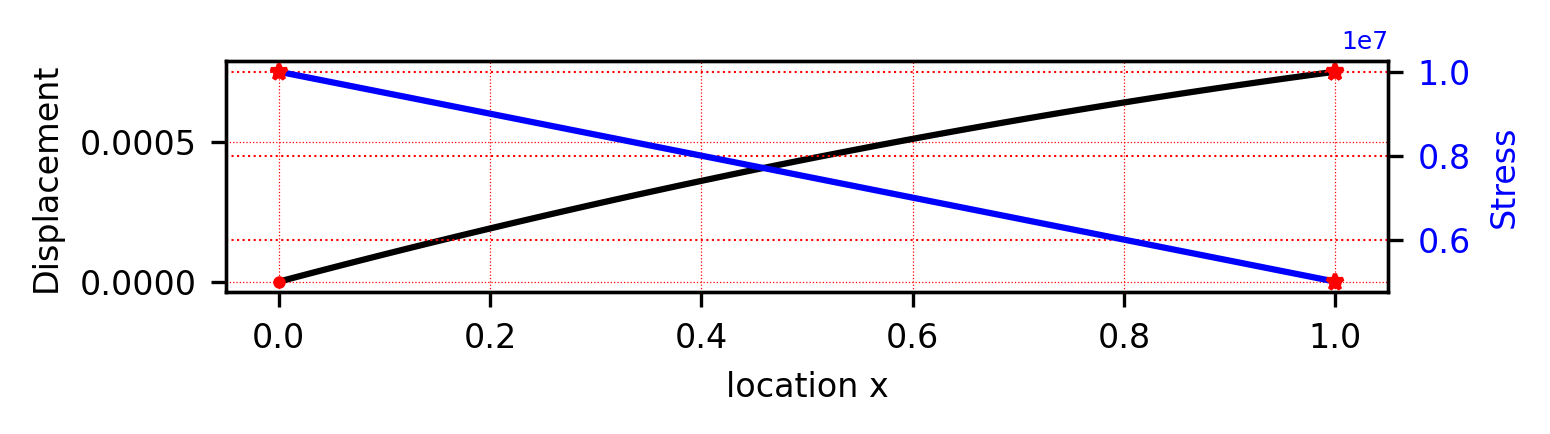

In [22]:
plot2curveS(ux_cq, title=title)           # ux: solution from method 1
#plt.savefig('images/beam_cq.png', dpi=500)  # save the plot to a file
plt.show()

2. 

In [23]:
E, A, l = symbols('E, A, l', nonnegative=True)   #l: length of the bar
x, q, bf, c0, c1 = symbols('x, q, b_f, c0, c1')

fL, fR, uL,uR = symbols('f_L, f_R, u_L, u_R')      
# fL: force at the Left-end; fR: force at the Right-end
# uL: displacement at the Left-end; uR: displacement at the Right-end

bf = sp.Function('b_f')(x)     
title = ["Displacement", "Stress"]

# Consider the distrubted force is a constant q 
bf = (100*x)+1000
u = solver1D2(E, A, bf, l, uL, fR, key='force')

# chech whether the DE is satisfied. 
print(f'Is solution correct? {u[2] == -bf/E/A}') 
u                    # solutions: u; E*u,x; u,xx

output from solver1D2(): u, 𝜎, u_xx
Is solution correct? False


In [24]:
# For a specifed set of parameters (unit values): 
ux=[u[i].subs({E:1e10,A:0.0002,l:1,uL:0,fR:0}) for i in range(len(u))]
ux

Maximum Displacement value=2.667e-04, at x=1.0
Maximum Stress value=5.250e+06, at x=0.0
Extreme Displacement values=[ 2.667e-04],
    at x=[ 1.000e+00]
Critical Stress values=[ 0.000e+00],
    at x=[ 1.000e+00]
Displacement values at boundary =(0.0, 0.0002666666666666666)
Stress values at boundary =(5250000.0, 0.0)



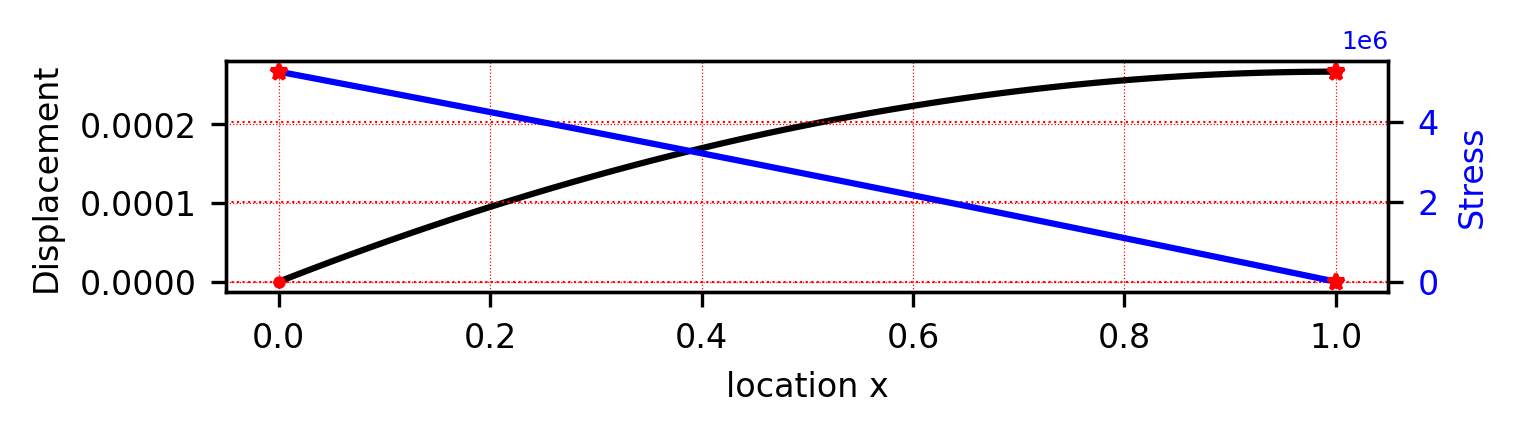

In [25]:
plot2curveS(ux, title=title)           # ux: solution from method 1
#plt.savefig('images/beam_cq.png', dpi=500)  # save the plot to a file
plt.show()